<a href="https://colab.research.google.com/github/m-riddle-codes/ARA/blob/main/004_pd1pdl1_compound_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is designed for cheminformatics analysis, specifically focusing on clustering and visualizing a dataset of chemical compounds that interact with the PD1/PDL1 complex. Utilizing Python, pandas for data handling, RDKit for cheminformatics tasks, and matplotlib for visualizations, users will navigate through the process of loading a chemical dataset, generating molecular fingerprints, calculating similarities, and clustering molecules based on their similarities. The clustered molecules will then be analyzed and visualized to provide insights into their distribution and activities.



---
# Learning Objectives

* Gain hands-on experience in using RDKit, a popular open-source cheminformatics library.
Learn to convert SMILES strings to RDKit Mol objects and understand the representation of chemical compounds in computational models.


* Understand the concept of molecular fingerprints and their role in representing chemical structures for computational analysis.
Learn to generate fingerprints for a set of molecules using RDKit.


* Explore the Tanimoto similarity metric, its calculation, and its application in measuring the similarity between molecular fingerprints.


* Apply the Butina clustering algorithm to group similar molecules together, based on their Tanimoto similarities.
Analyze the resulting clusters to understand the distribution of compounds and their potential biological activities.


* Utilize matplotlib to create visual representations of the clustered data, aiding in the interpretation of clustering results.
Learn to customize and save plots in the Google Colab environment, including saving to Google Drive.


* Analyze and interpret the clustering results to gain insights into the chemical space covered by the dataset.
Explore the relationship between molecular structures and their associated pIC50 values, contributing to an understanding of the molecules’ biological activities.


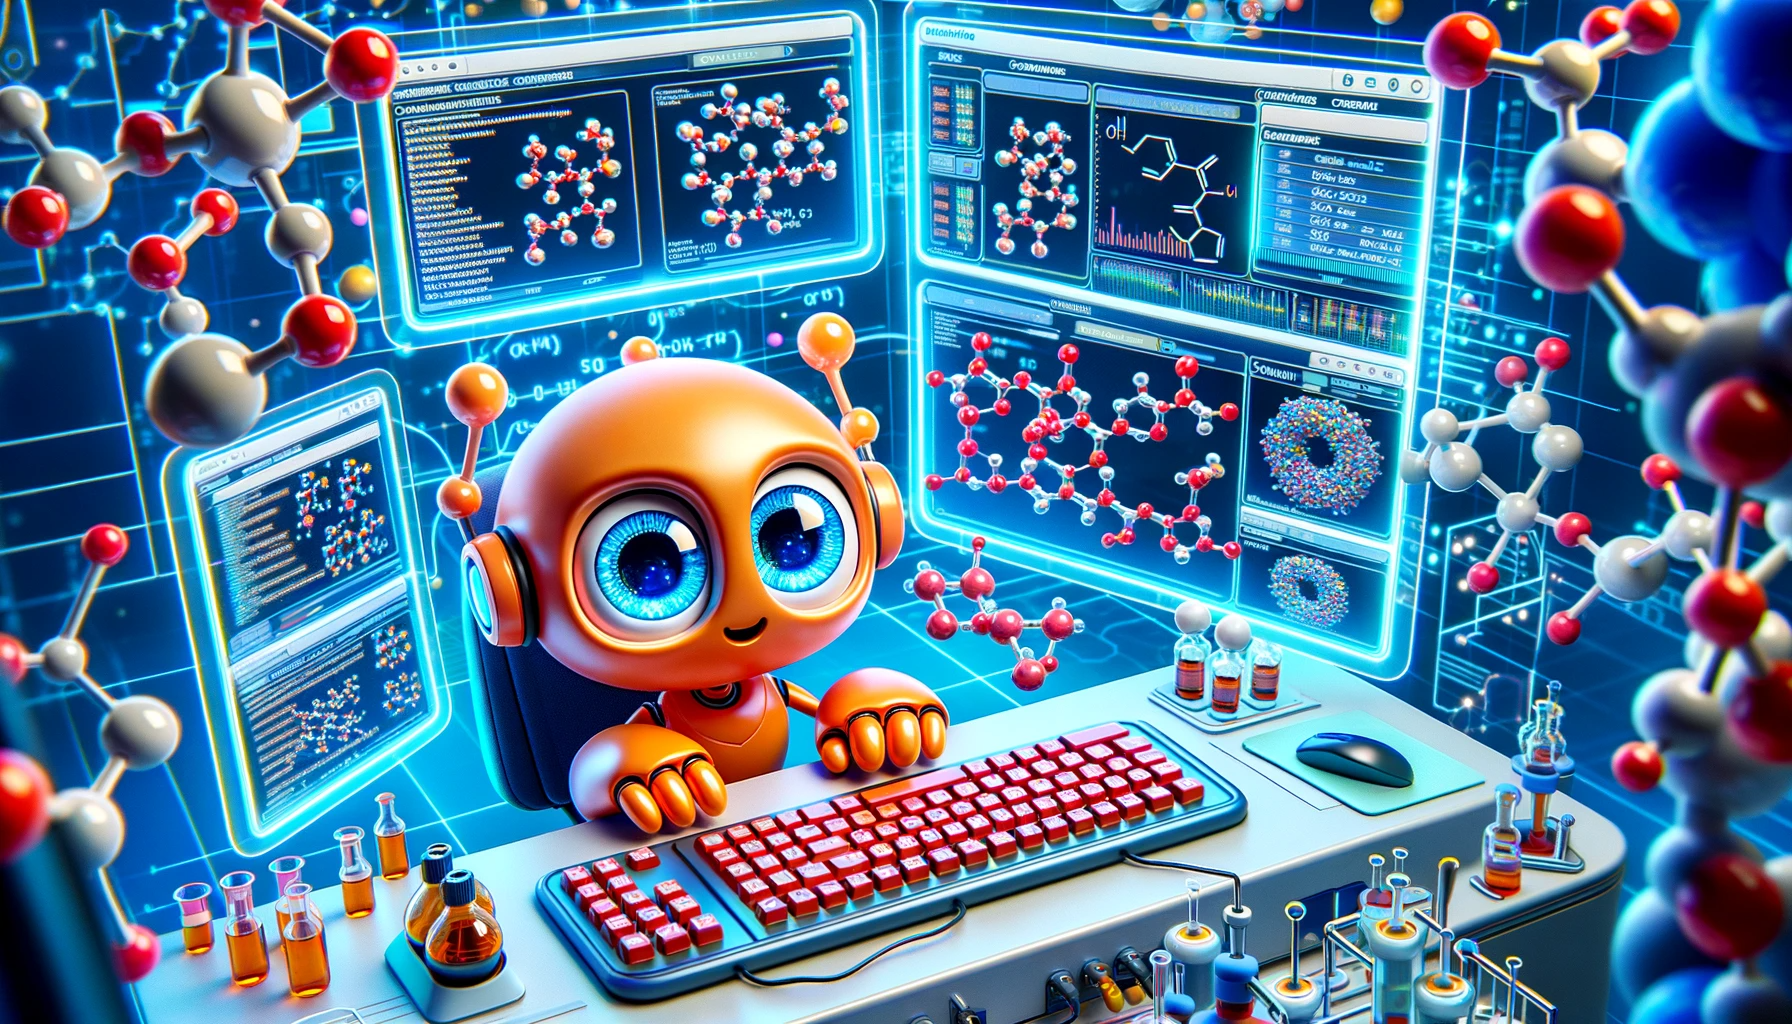

In [ ]:
# @title Default title text
from IPython.display import Image
Image(filename='cluster.png')


We begin by installing RDKit, a collection of cheminformatics and machine learning tools. It is essential to ensure that we have all the necessary tools at our disposal for the tasks ahead.

In [ ]:
!pip install rdkit-pypi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 19.0 MB/s eta 0:00:00


Now, we're importing all the necessary libraries that will be used throughout the notebook for various purposes including data handling, visualization, and cheminformatics tasks.

* import time: Used for handling time-related tasks, such as delaying code execution and measuring execution time.

* import random: Enables the generation of random numbers and the shuffling of sequences.

* import pandas as pd: A pivotal library for data handling and analysis, offering efficient data structures like DataFrames.

* import numpy: Essential for numerical computing, offering support for arrays and mathematical functions.

* import matplotlib.pyplot as plt: Facilitates the creation of a variety of visualizations to enhance data analysis.

* from rdkit import Chem: Offers tools for chemical informatics, including handling and analysis of chemical structures.

* from rdkit import DataStructs: Handles specialized data structures for cheminformatics and machine learning within RDKit.

* from rdkit.ML.Cluster import Butina: Used for clustering molecular data to group similar molecules effectively.

* from rdkit.Chem import Draw: Provides visualization tools for chemical structures.

* from rdkit.Chem import rdFingerprintGenerator: Generates fingerprints for molecules, aiding in their comparison and clustering based on structural similarities.

In [ ]:
import time
import random
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

We then set a seed for random number generation to ensure reproducibility. It's crucial to maintain consistent results for analysis and interpretation.

In [ ]:
def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import os
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything()

In [ ]:
compound_df = pd.read_csv("pd1pdl1molecules.csv")
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (570, 11)


Unnamed: 0 molecule_chembl_id     IC50 units  \
0           0      CHEMBL4529967  0.00008    nM   
1           1      CHEMBL5202283  0.00008    nM   
2           2      CHEMBL5182195  0.04000    nM   
3           3      CHEMBL4865838  0.05100    nM   
4           4      CHEMBL4862360  0.05800    nM   

                                              smiles      pIC50  \
0  N#Cc1cc(COc2cc(CCc3cccc(-c4ccccc4)c3Br)c(Cl)cc...  13.096910   
1  N#Cc1cc(COc2cc(CCc3cccc(-c4ccccc4)c3Br)ccc2CN2...  13.096910   
2  Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN[C@H](CCO)C(=O...  10.397940   
3  CS(=O)(=O)c1cncc(COc2nc(O[C@H]3CCc4c(-c5cccc6c...  10.292430   
4  C[C@@](CO)(NCc1cc(Cl)c(O[C@H]2CCc3c(-c4cccc5c4...  10.236572   

   molecular_weight  n_hba  n_hbd     logp  ro5_fulfilled  
0        643.123732      5      1  7.83948          False  
1        609.162704      5      1  7.18608          False  
2        948.290399     12      6  8.40190          False  
3       1144.251648     18      4  6.37760          False  
4       1120.251648     18      6  6.18840          False

In [ ]:
# Create molecules from SMILES and store in array
compounds = []

# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need the index so we use _ instead
# note how we are slicing the dataframe to only the columns we need now
for _, chembl_id, smiles, pic50 in compound_df[["molecule_chembl_id", "smiles", "pIC50"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id, pic50))

compounds[:5]


[(<rdkit.Chem.rdchem.Mol at 0x7ec5e37a3610>,
  'CHEMBL4529967',
  13.096910013008056),
 (<rdkit.Chem.rdchem.Mol at 0x7ec5e37a3680>,
  'CHEMBL5202283',
  13.096910013008056),
 (<rdkit.Chem.rdchem.Mol at 0x7ec5e37a37d0>,
  'CHEMBL5182195',
  10.397940008672036),
 (<rdkit.Chem.rdchem.Mol at 0x7ec5e37a3840>,
  'CHEMBL4865838',
  10.292429823902063),
 (<rdkit.Chem.rdchem.Mol at 0x7ec5e37a38b0>,
  'CHEMBL4862360',
  10.236572006437065)]

In [ ]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx, _ in compounds]  # note the added underscore _

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))


Number of compounds converted: 570
Fingerprint length per compound: 2048


# Tanimoto similarity and distance matrix
Now that we generated fingerprints, we move on to the next step: The identification of potential cluster centroids. For this, we define functions to calculate the Tanimoto similarity and distance matrix.

In [ ]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [ ]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.92, distance: 0.08


In [ ]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.082815734989648,
 0.4311270125223614,
 0.45856353591160226,
 0.52751677852349,
 0.5480769230769231]

In [ ]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)

Elements in the triangular matrix (162165) == tanimoto_distance_matrix(fingerprints) (162165)


# Clustering molecules: Centroids and exclusion spheres
In this part, we cluster the molecules and look at the results.

Define a clustering function.

In [ ]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [ ]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  80
# clusters with only 1 compound:  35
# clusters with >5 compounds:  22
# clusters with >25 compounds:  8
# clusters with >100 compounds:  0


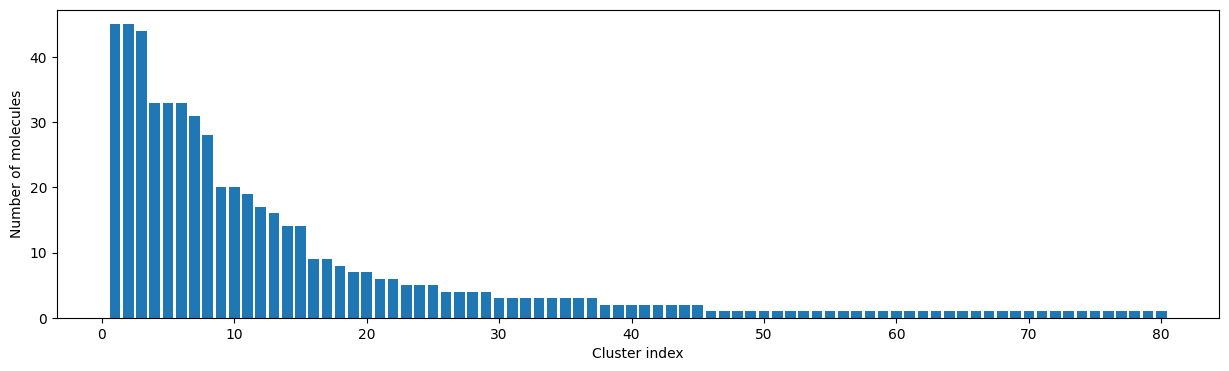

In [ ]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

**How to pick a reasonable cutoff?**


Since the clustering result depends on the threshold chosen by the user, we will have a closer look on the choice of a cutoff.

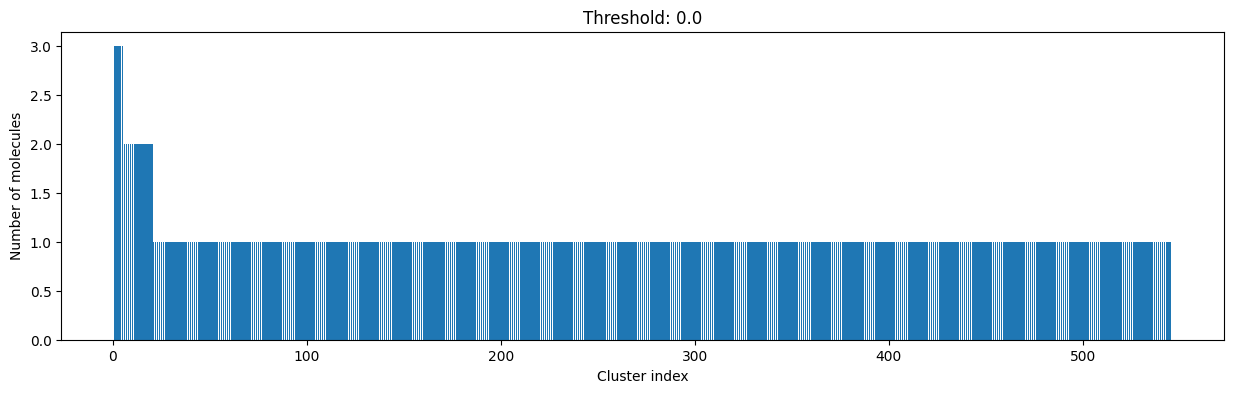

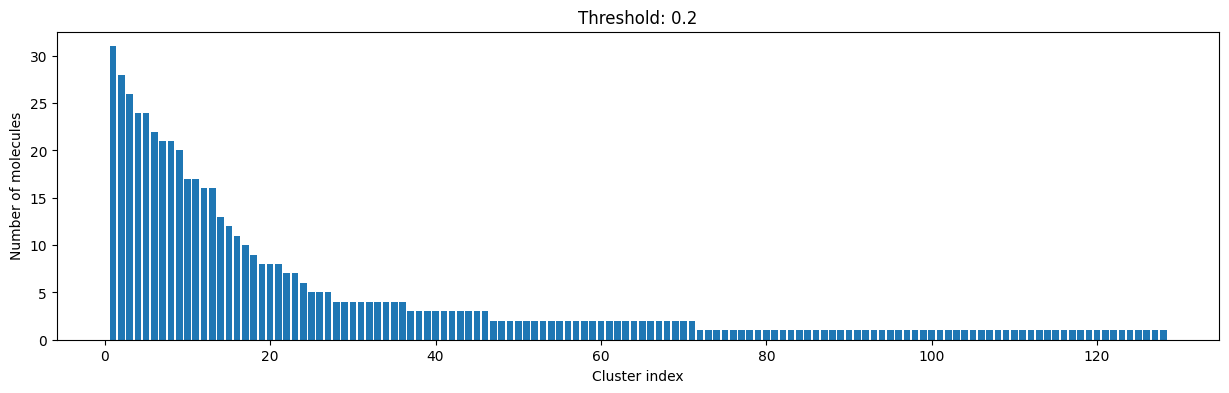

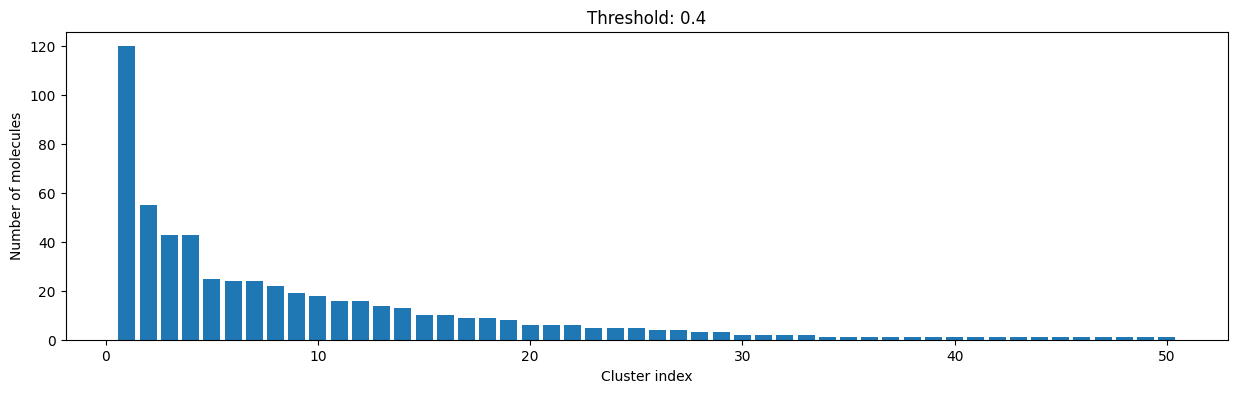

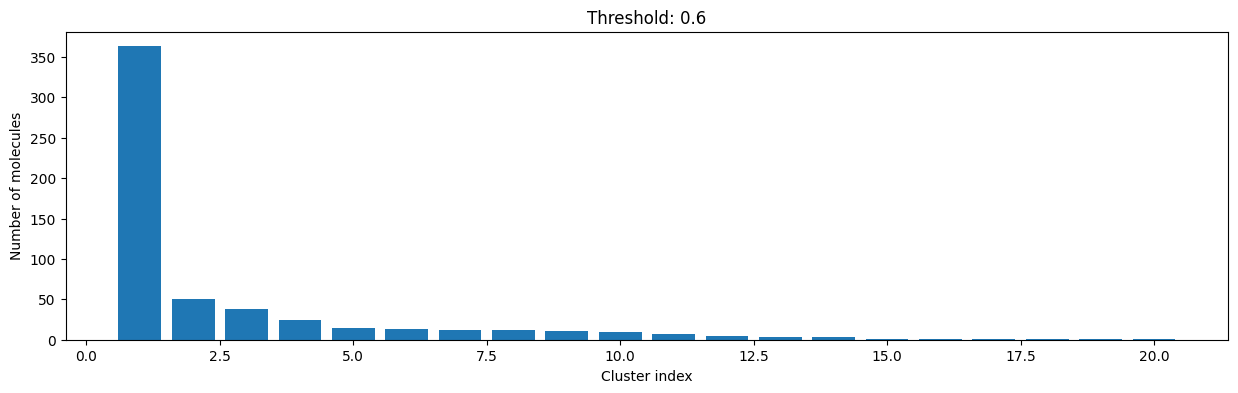

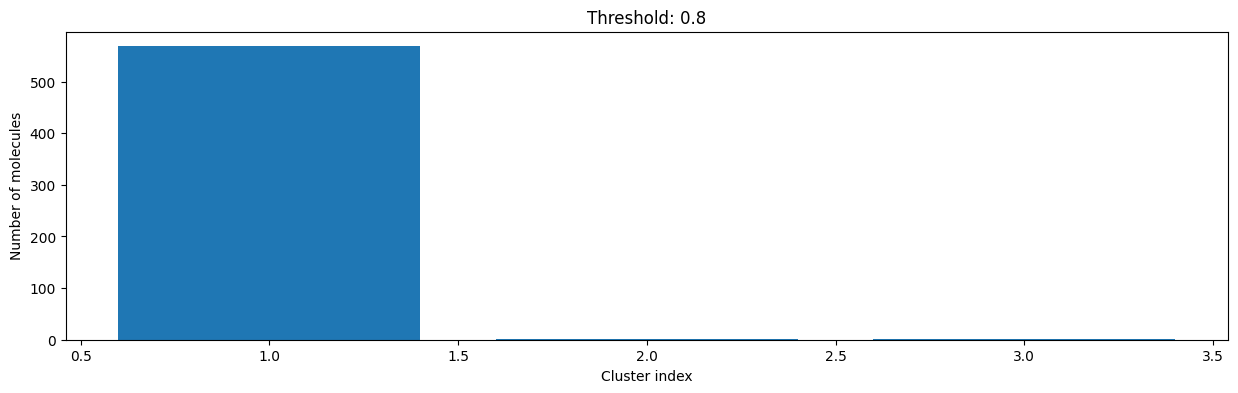

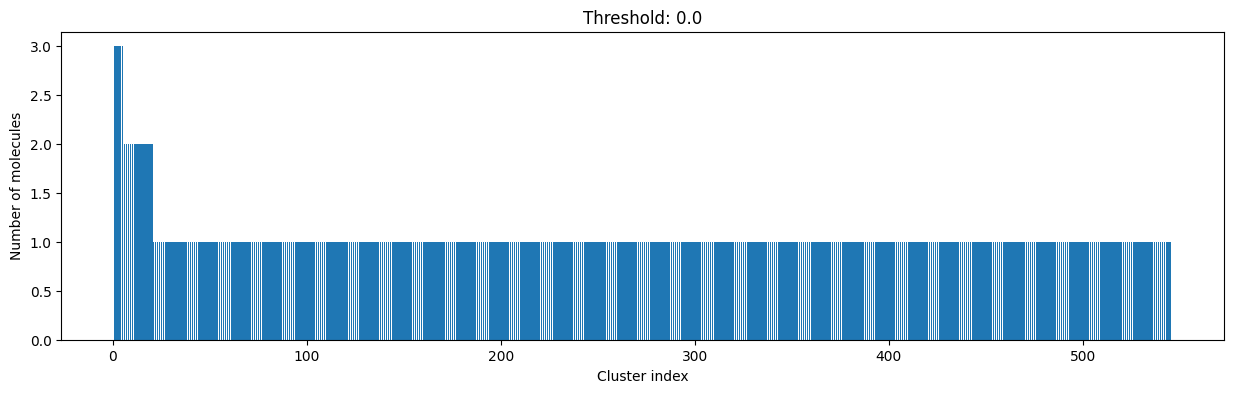

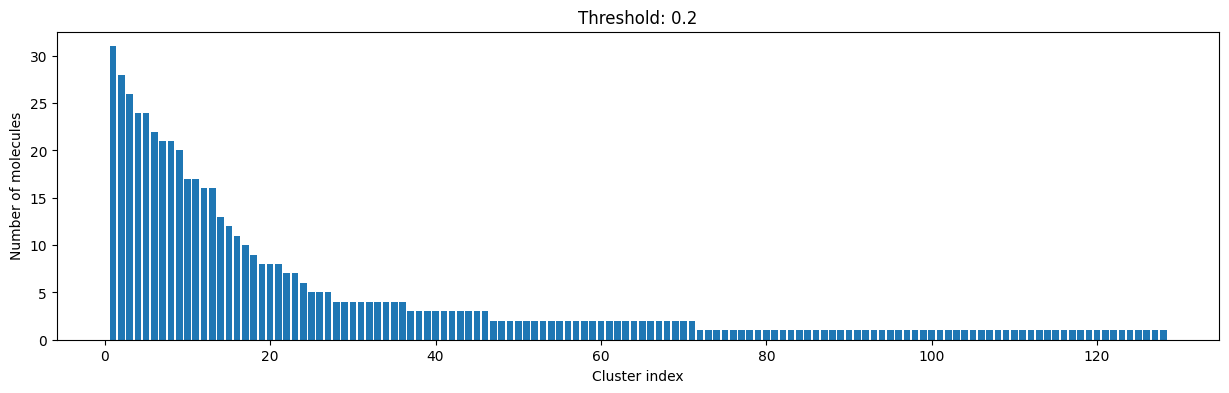

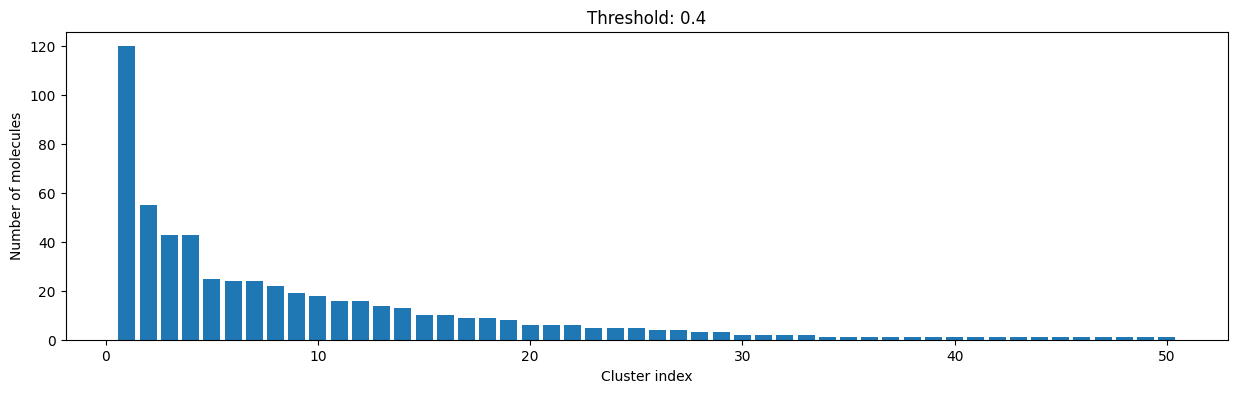

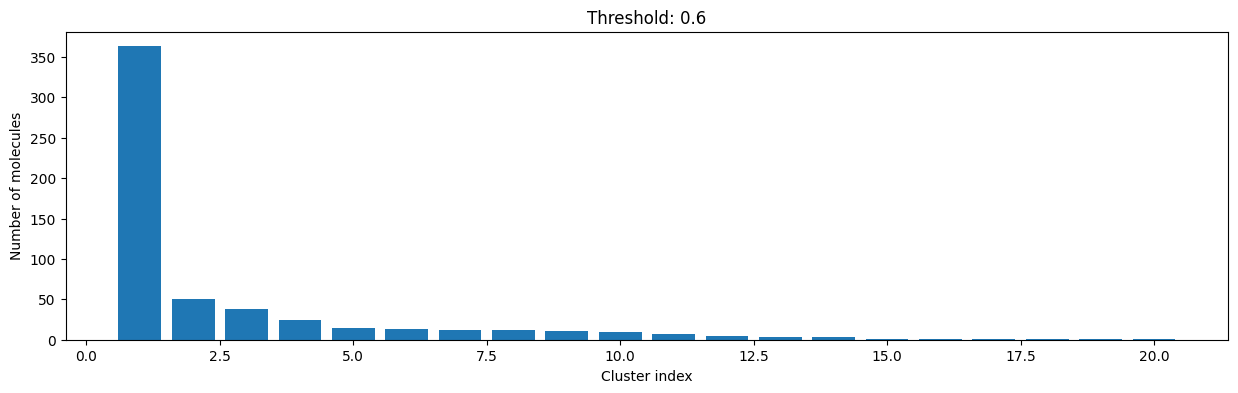

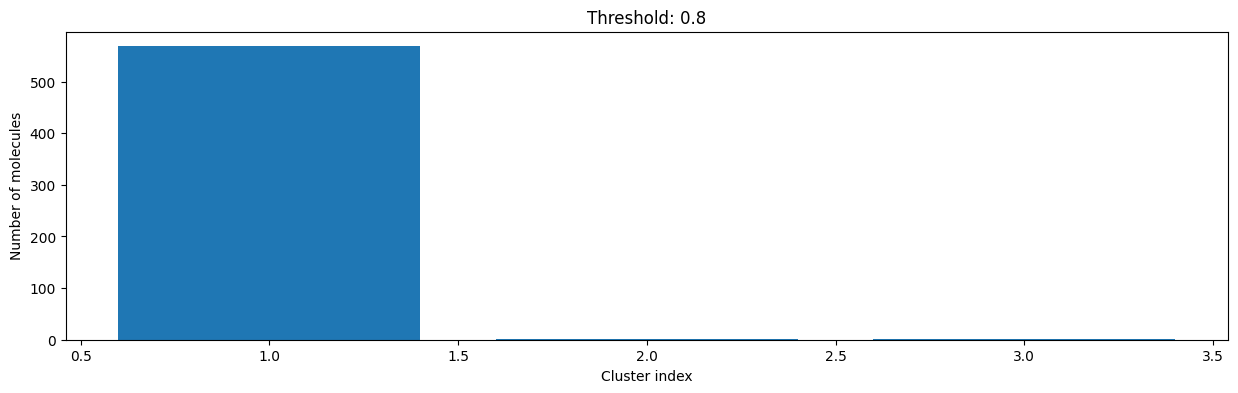

In [ ]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


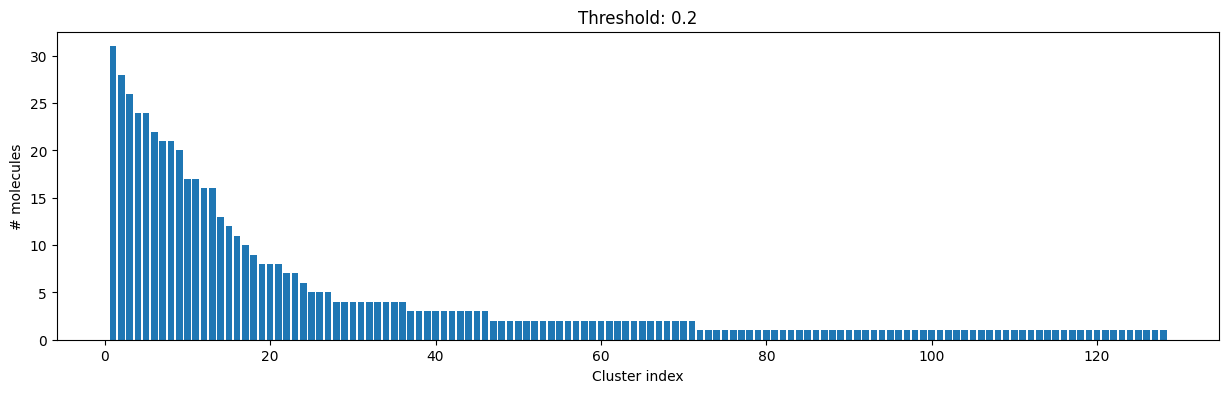

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of clusters: 128 from 570 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 31
Similarity between two random points in same cluster: 0.98
Similarity between two random points in different cluster: 0.27


In [ ]:
# Import necessary libraries (assuming they are not imported yet)
import matplotlib.pyplot as plt
from rdkit import DataStructs


cutoff = 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
plt.show()

# Mount Google Drive (only run this once in your notebook)
from google.colab import drive
drive.mount('/content/drive')

# Save the plot to a folder in your Google Drive
path_to_save = "/content/drive/MyDrive/Graduation"  # replace 'your_folder_name_here' with your desired folder
fig.savefig(
    f"{path_to_save}cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

# Assuming compounds is already defined
print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)


All 31 molecules from largest cluster:


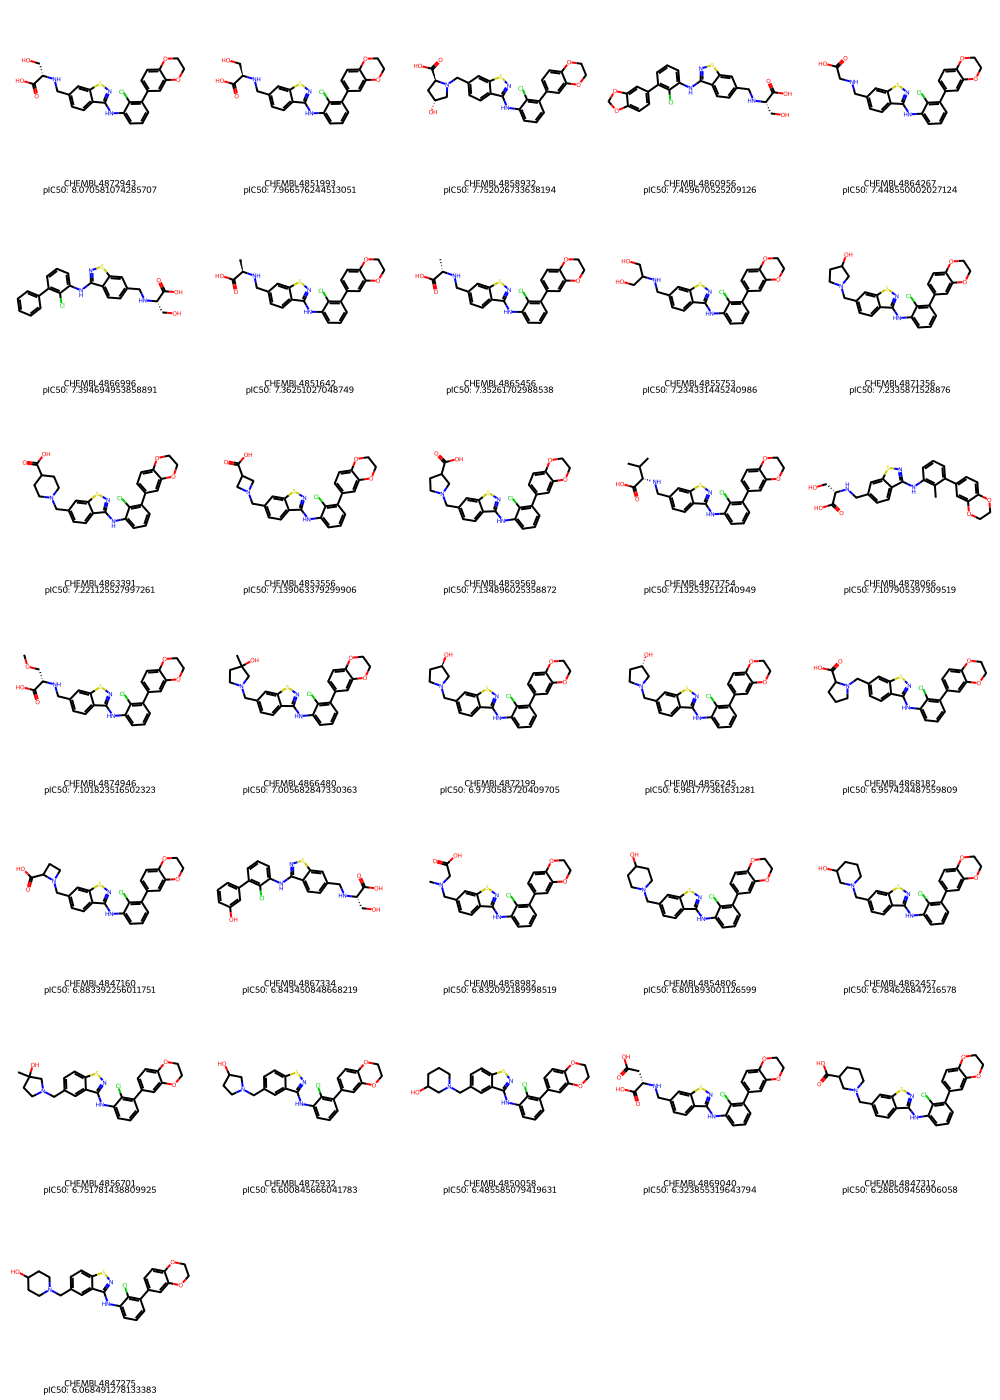

In [ ]:
print("All 31 molecules from largest cluster:")

# Sort the indices of the molecules in clusters[0][:31] by pIC50 values in descending order
sorted_indices = sorted(clusters[0][:31], key=lambda i: compounds[i][2], reverse=True)

# Draw molecules with legends, placing the pIC50 value below the ChEMBL_ID with added spacing
Draw.MolsToGridImage(
    [compounds[i][0] for i in sorted_indices],
    legends=[f"{compounds[i][1]}\n\n\n\xa0\n\xa0\npIC50: {compounds[i][2]}" for i in sorted_indices],
    molsPerRow=5,
)

In [ ]:
from rdkit import Chem
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the DATA directory path in Google Drive
DATA = "/content/drive/MyDrive/Graduation"  # replace 'your_folder_name_here' with your desired folder

# Check and create the directory if it doesn't exist
if not os.path.exists(DATA):
    os.makedirs(DATA)

# Sort the indices of the molecules in clusters[0] by pIC50 values in descending order
sorted_indices = sorted(clusters[0], key=lambda i: compounds[i][2], reverse=True)

# Construct the full path for the SDF file
sdf_path = os.path.join(DATA, "ppp.sdf")

# Write molecules to the SDF file
sdf = Chem.SDWriter(sdf_path)
for index in sorted_indices:
    mol, label, pic50 = compounds[index]  # Extract molecule, label, and pIC50
    mol.SetProp("_Name", f"{label}\npIC50: {pic50}")  # Set name with pIC50 value below the label
    sdf.write(mol)
sdf.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ten molecules from second largest cluster:


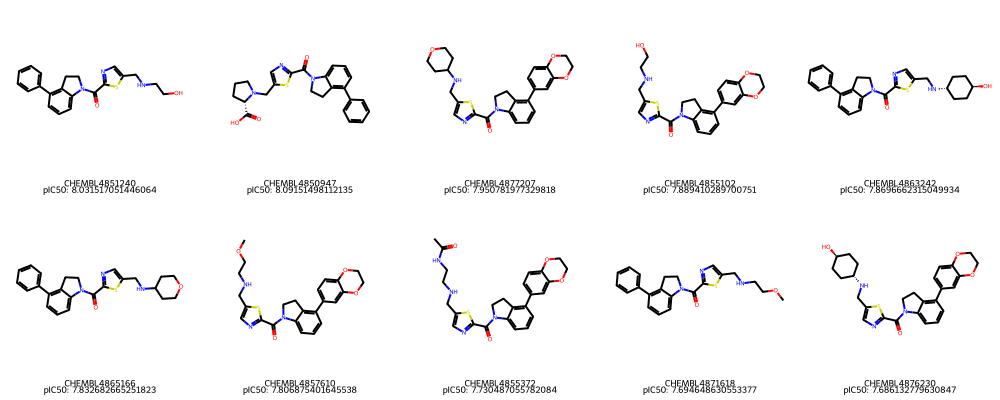

In [ ]:
print("Ten molecules from second largest cluster:")

# Draw molecules with legends, placing the pIC50 value below the ChEMBL_ID
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[f"{compounds[i][1]}\npIC50: {compounds[i][2]}" for i in clusters[1][:10]],
    molsPerRow=5,
)


For comparison, we have a look at the cluster centers of the first 10 clusters.

Ten molecules from first 10 clusters:


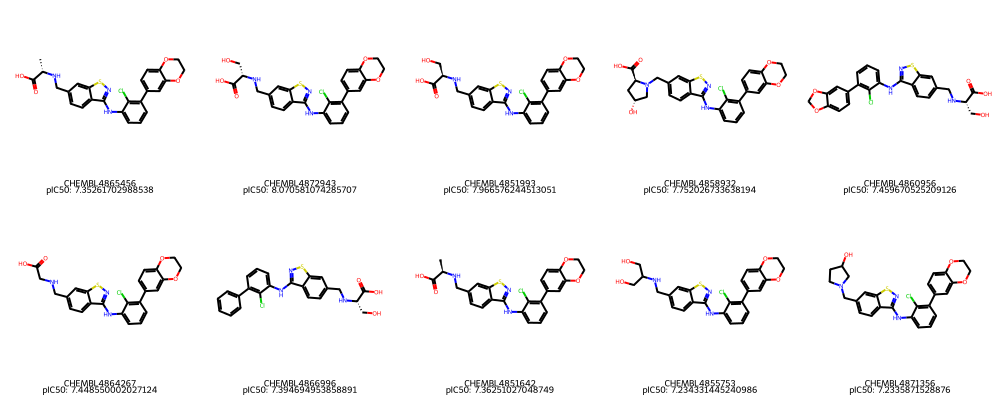

In [ ]:
print("Ten molecules from first 10 clusters:")

# Draw molecules with legends, placing the pIC50 value below the ChEMBL_ID with added spacing
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[f"{compounds[i][1]}\n\n\n\xa0\n\xa0\npIC50: {compounds[i][2]}" for i in clusters[0][:10]],
    molsPerRow=5,
)

In [ ]:
# Extract the names (ChEMBL_IDs) and pIC50 values for the sorted molecules
sorted_names = [compounds[i][1] for i in sorted_indices]
sorted_pic50_values = [compounds[i][2] for i in sorted_indices]

# Create a DataFrame
df_sorted = pd.DataFrame({
    'Name': sorted_names,
    'pIC50': sorted_pic50_values
})

print(df_sorted)

             Name     pIC50
0   CHEMBL4872943  8.070581
1   CHEMBL4851993  7.966576
2   CHEMBL4858932  7.752027
3   CHEMBL4860956  7.459671
4   CHEMBL4864267  7.448550
5   CHEMBL4866996  7.394695
6   CHEMBL4851642  7.362510
7   CHEMBL4865456  7.352617
8   CHEMBL4855753  7.234331
9   CHEMBL4871356  7.233587
10  CHEMBL4863391  7.221126
11  CHEMBL4853556  7.139063
12  CHEMBL4859569  7.134896
13  CHEMBL4873754  7.132533
14  CHEMBL4878066  7.107905
15  CHEMBL4874946  7.101824
16  CHEMBL4866480  7.005683
17  CHEMBL4872199  6.973058
18  CHEMBL4856245  6.961777
19  CHEMBL4868182  6.957424
20  CHEMBL4847160  6.883392
21  CHEMBL4867334  6.843451
22  CHEMBL4858982  6.832092
23  CHEMBL4854806  6.801893
24  CHEMBL4862457  6.784627
25  CHEMBL4856701  6.751781
26  CHEMBL4875932  6.600846
27  CHEMBL4850058  6.485585
28  CHEMBL4869040  6.323855
29  CHEMBL4847312  6.286509
30  CHEMBL4847275  6.068491


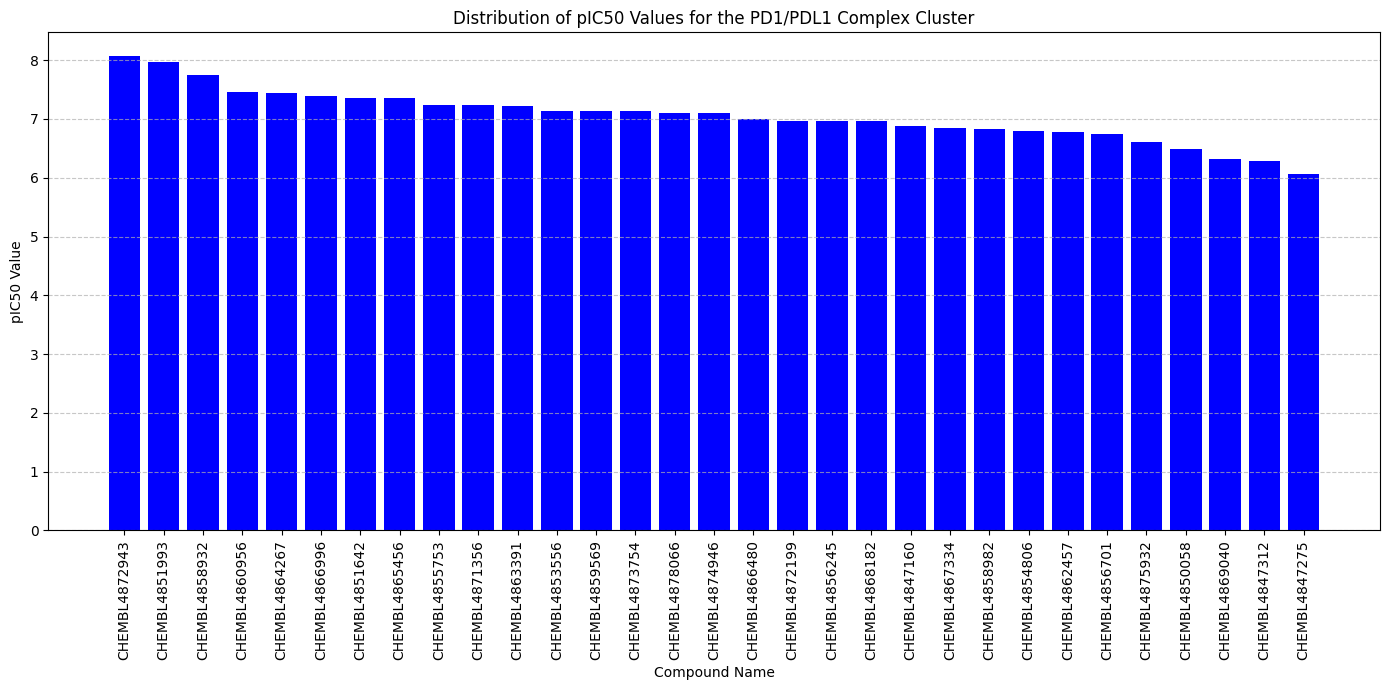

In [ ]:
data_2 = {
    "Name": ["CHEMBL4872943", "CHEMBL4851993", "CHEMBL4858932", "CHEMBL4860956", "CHEMBL4864267", "CHEMBL4866996",
             "CHEMBL4851642", "CHEMBL4865456", "CHEMBL4855753", "CHEMBL4871356", "CHEMBL4863391", "CHEMBL4853556",
             "CHEMBL4859569", "CHEMBL4873754", "CHEMBL4878066", "CHEMBL4874946", "CHEMBL4866480", "CHEMBL4872199",
             "CHEMBL4856245", "CHEMBL4868182", "CHEMBL4847160", "CHEMBL4867334", "CHEMBL4858982", "CHEMBL4854806",
             "CHEMBL4862457", "CHEMBL4856701", "CHEMBL4875932", "CHEMBL4850058", "CHEMBL4869040", "CHEMBL4847312",
             "CHEMBL4847275"],
    "pIC50": [8.070581, 7.966576, 7.752027, 7.459671, 7.448550, 7.394695, 7.362510, 7.352617, 7.234331, 7.233587,
              7.221126, 7.139063, 7.134896, 7.132533, 7.107905, 7.101824, 7.005683, 6.973058, 6.961777, 6.957424,
              6.883392, 6.843451, 6.832092, 6.801893, 6.784627, 6.751781, 6.600846, 6.485585, 6.323855, 6.286509,
              6.068491]
}

# Convert data to DataFrame
df_2 = pd.DataFrame(data_2)

# Plotting the pIC50 values for the second dataset in blue
plt.figure(figsize=(14, 7))
plt.bar(df_2['Name'], df_2['pIC50'], color='blue')
plt.xlabel('Compound Name')
plt.ylabel('pIC50 Value')
plt.title('Distribution of pIC50 Values for the PD1/PDL1 Complex Cluster')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()